# Deep Learning

Machines are getting extremely personal in their ability to reason and react with human level intelligence. Take for example your personal smartphone, with simple sensors, is able to precisely tell if you are currently walking, running, sleeping, or climbing.

Take the dataset at https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names. The Human Activity Recognition dataset which presumably is what is being recorded by the sensors in the phone. We want to process and measure if we can predict the human activity accurately.

## Data

Download the dataset from https://archive.ics.uci.edu/ml/machine-learning-databases/00240/. The dataset is normalized readings from the accelerometers and gyrometers measuring X, Y, Z motions respectively from willing people wearing smartwatches that le their activity be recorded too. We will use this training set to develop activity prediction system. 

In [1]:
# Data from the web
import requests, zipfile, StringIO

# Let us read the HAR data from UCI -- https://archive.ics.uci.edu/ml/machine-learning-databases/00240/
uri = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip'

# Download file to memory; caution to fit in memory
download_file = lambda uri: StringIO.StringIO(requests.get(uri).content)

# Download it and pin it in memory
zip_data = download_file(uri)

# Pointer to a file in the zip file
file_in_zip = lambda filepath: zipfile.ZipFile(zip_data).open('UCI HAR Dataset/' + filepath)

# We will call our "activity" y_label
y_label = 'activity'

# Parse out all the files and compile them together
def get_training_set():
    # Read the X column names
    har_data_labels = pd.read_csv(file_in_zip('features.txt'), sep="\s+", names=['id', 'feature_name'])

    # Read the activity names
    activity_map = { str(row.id):row.label_name for i, row in pd.read_csv(file_in_zip('activity_labels.txt'), sep="\s+", names=['id', 'label_name']).iterrows() }

    # Read the X
    har_data_x = pd.read_csv(file_in_zip('train/X_train.txt'), sep="\s+", names=har_data_labels.feature_name.tolist())

    # Read the Y
    har_data_y = pd.read_csv(file_in_zip('train/y_train.txt'), sep="\s+", names=[y_label])

    # Map the label into a readable form
    har_data_y[y_label] = har_data_y[y_label].apply(lambda x: activity_map[str(x)])

    # Training data, merge X and Y
    har_data_train = pd.concat([har_data_y, har_data_x], axis=1)

    # Read the X test
    har_test_x = pd.read_csv(file_in_zip('test/X_test.txt'), sep="\s+", names=har_data_labels.feature_name.tolist())

    # Read the Y test
    har_test_y = pd.read_csv(file_in_zip('test/y_test.txt'), sep="\s+", names=['activity'])

    # Map the label into a readable form
    har_test_y[y_label] = har_test_y[y_label].apply(lambda x: activity_map[str(x)])

    # Test data, merge X and Y
    har_data_test = pd.concat([har_test_y, har_test_x], axis=1)

    # Return the two frames as tuple
    return (har_data_train, har_data_test, sorted(activity_map.items()))

(train_data, test_data, activity_map) = get_training_set()

# Display a preview of the training data
display(train_data.head())

# Display a preview of the test data
display(test_data.head())

,activity,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,...,"angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,STANDING,0.29,-0.02,-0.13,...,-0.02,-0.84,0.18,-0.06
1,STANDING,0.28,-0.02,-0.12,...,0.70,-0.84,0.18,-0.05
2,STANDING,0.28,-0.02,-0.11,...,0.81,-0.85,0.18,-0.05
3,STANDING,0.28,-0.03,-0.12,...,-0.49,-0.85,0.18,-0.05
4,STANDING,0.28,-0.02,-0.12,...,-0.62,-0.85,0.19,-0.04


,activity,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,...,"angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,STANDING,0.26,-0.02,-0.01,...,0.27,-0.72,0.28,-0.06
1,STANDING,0.29,-0.01,-0.12,...,0.92,-0.70,0.28,-0.08
2,STANDING,0.28,-0.03,-0.12,...,0.15,-0.70,0.28,-0.08
3,STANDING,0.27,-0.03,-0.12,...,0.30,-0.70,0.28,-0.08
4,STANDING,0.27,-0.03,-0.13,...,-0.12,-0.69,0.29,-0.07


## Dimensionality

The data is obviously a rich dataset with many features. Thankfully these datasets are already normalized into the [-1,+1] range.

The size of the feature space, and thus presumably the non orthogonal separation surface in the hyperspace, makes it suitable for analyzing by neural networks (like TensorFlow).

In [2]:
# Create handy functions to slice dataframe into labels and attributes
# aka separate unlabeled dataset (raw attributes/X) from labels (Y)
X_data = lambda df: df.copy().drop([y_label], axis=1)
Y_data = lambda df: df[y_label]

## Logistic Regression

First, let us analyze this dataset with a simpler logistic regression model.

In [3]:
from sklearn import linear_model, datasets, metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Training Logistic regression
logistic_classifier = linear_model.LogisticRegression(C=100.0)

# Train and predict the outcomes for test set
y_pred = logistic_classifier.fit(X_data(train_data), Y_data(train_data)).predict(X_data(test_data))

# The original test data already had the "real" outcomes.
y_real = Y_data(test_data)

# Merge the real and predicted together to display
display(pd.DataFrame(zip(y_pred, y_real), columns=['Predicted Activity', 'Real Activity']))

,Predicted Activity,Real Activity
0,STANDING,STANDING
1,STANDING,STANDING
2,SITTING,STANDING
...,...,...
2944,WALKING_UPSTAIRS,WALKING_UPSTAIRS
2945,WALKING_UPSTAIRS,WALKING_UPSTAIRS
2946,WALKING_UPSTAIRS,WALKING_UPSTAIRS


## Accuracy

How well did we do with a simple logistic regression model and where exactly are we going wrong?

In [4]:
# Print the accuracy numbers to the screen
display(HTML('<h3>Accuracy with logistic regression model is: {0:2f}%</h3>'.format(100*accuracy_score(y_pred, y_real))))

Accuracy at 96.2% for a simple logistic regression model is not bad. But where exactly is the confusion coming from? We can plot the confusion matrix to spot where false positives (upper triangular) and false negatives (lower triangular) occur.

,WALKING,WALKING_UPSTAIRS,WALKING_DOWNSTAIRS,SITTING,STANDING,LAYING
WALKING,495,0,1,0,0,0
WALKING_UPSTAIRS,23,447,0,1,0,0
WALKING_DOWNSTAIRS,3,6,411,0,0,0
SITTING,0,4,0,429,55,3
STANDING,1,0,0,13,518,0
LAYING,0,0,0,0,0,537


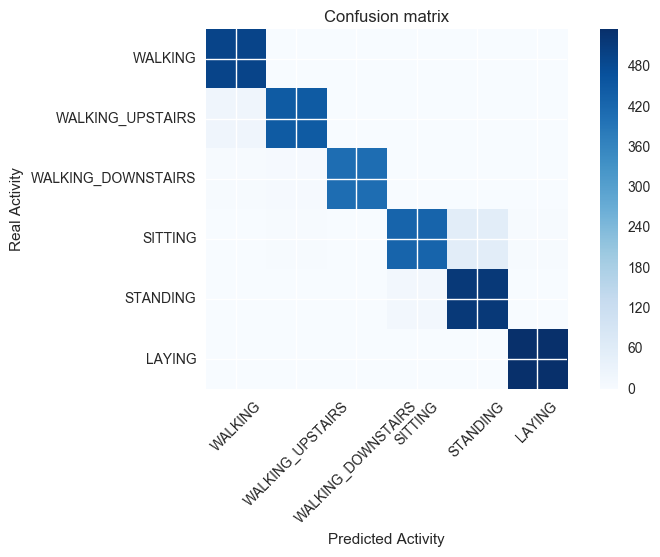

In [5]:
# Draw the confusion matrix
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=None):
    # Show the confusion matrix as an image
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    # Put labels on axis
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    # Pack it together
    plt.tight_layout()
    
    # Render the DataFrame as a table for easy view
    cmpd = pd.DataFrame(cm, columns=labels)
    cmpd.index = labels
    display(HTML('<b>Confusion matrix</b>'))
    display(cmpd)
    plt.ylabel('Real Activity')
    plt.xlabel('Predicted Activity')


# Labels
labels = map(lambda x: x[1], activity_map)
# Compute confusion matrix
cm = confusion_matrix(y_real, y_pred, labels=labels)

# Show the confusion matrix
plt.figure()
plot_confusion_matrix(cm, labels=labels)
plt.show()

## Findings

We find that the machine does very well, but most confused (misclassifying) instances during "walking upstairs" and "walking downstairs" as "walking". A genuine confusion, you may surmise, if the slope of the walk is moderate, it is perhaps easy to imagine why the confusion may occur.

Similarly when the subject is standing or sitting, there is no lateral (X and Y axis) motion. Stationary motions (sitting and standing) are causing confusion as well.

But out of a total of 2947 test observations, achieving 96% accuracy is a great start.

## TensorFlow

TensorFlow is the deep learning framework by Google. See more here -- https://www.tensorflow.org/. The neural network should yield better results if the separation surface is non linear.

In [6]:
import tensorflow as tf
from tensorflow.contrib import learn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler

# suppress tensorflow WARN verbosity
tf.logging.set_verbosity(tf.logging.ERROR)

# The original test data already had the "real" outcomes.
y_numbers = pd.concat([Y_data(train_data), Y_data(
    test_data)])  # Get all possible activity names again from the data

# Turn the activity labels into integers
activity_encoder = LabelEncoder().fit(y_numbers)

# We do not need to scale the values really because they are already in the -1 to +1 range.
# But let us scale them into a unit normal scale so sigmoid functions of neural networks make sense
scaler = StandardScaler()

# Map the activity names (like Walking, Standing, Sitting into 0, 1, 2 etc)
Y_train_numeric = activity_encoder.transform(
    Y_data(train_data))  # Training labels
Y_test_numeric = activity_encoder.transform(Y_data(test_data))  # Test labels

# Number of distinct classes in the multiclass classifier
n_classes = len(activity_encoder.classes_)

# Build the classifier -- TensorFlow graph that is...
# cast all values to float32 to be tensorflow friendly
classifier = learn.DNNClassifier(
    feature_columns=learn.infer_real_valued_columns_from_input(
        X_data(train_data).astype('float32')),
    hidden_units=[len(train_data.columns.values), n_classes],
    n_classes=n_classes)

# Hash it into a pipeline so we can use more transformations in the pipeline
# Scale the vectors before they go into the network
pipeline = Pipeline([('Scaler', scaler), ('DNNclassifier', classifier)])

# Train the Tensorflow network
pipeline.fit(X_data(train_data), Y_train_numeric, DNNclassifier__steps=200)

Pipeline(steps=[('Scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('DNNclassifier', <tensorflow.contrib.learn.python.learn.estimators.dnn.DNNClassifier object at 0x121a502d0>)])

## Predict

In [7]:
# For test set, blind-fold real activity, and predict the outcome
y_pred = activity_encoder.inverse_transform(list(pipeline.predict(X_data(test_data))))

# The original test data already had the "real" outcomes.
# Put the real and predicted activity from tensorflow together
y_real = Y_data(test_data)

# Merge the real and predicted together to display
display(pd.DataFrame(zip(y_pred, y_real), columns=['Predicted Activity', 'Real Activity']))

,Predicted Activity,Real Activity
0,STANDING,STANDING
1,STANDING,STANDING
2,STANDING,STANDING
...,...,...
2944,WALKING_UPSTAIRS,WALKING_UPSTAIRS
2945,WALKING_UPSTAIRS,WALKING_UPSTAIRS
2946,WALKING_UPSTAIRS,WALKING_UPSTAIRS


## Accuracy

How well did we do with a TensorFlow model and where exactly are we going wrong?

In [8]:
# Print the accuracy numbers to the screen
display(HTML('<h3>Accuracy with tensorflow model is: {0:2f}%</h3>'.format(100*accuracy_score(y_pred, y_real))))

Accuracy at 93% model is alright. But where exactly is the confusion coming from?

## Confusion Matrix

,WALKING,WALKING_UPSTAIRS,WALKING_DOWNSTAIRS,SITTING,STANDING,LAYING
WALKING,491,2,3,0,0,0
WALKING_UPSTAIRS,19,441,11,0,0,0
WALKING_DOWNSTAIRS,9,31,380,0,0,0
SITTING,0,1,0,442,45,3
STANDING,0,0,0,37,495,0
LAYING,0,0,0,0,1,536


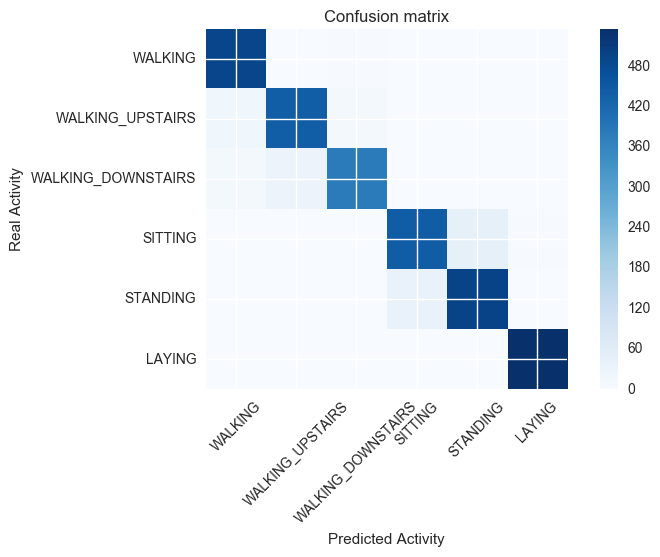

In [9]:
# Labels
labels = map(lambda x: x[1], activity_map)
# Compute confusion matrix
cm = confusion_matrix(y_real, y_pred, labels=labels)

# Show the confusion matrix
plt.figure()
plot_confusion_matrix(cm, labels=labels)
plt.show()

## Findings

We find that the tensorflow does alright with ~93% accuracy, but was most confused (misclassifying) instances during "walking upstairs" and "walking downstairs" as "walking". A genuine confusion, you may surmise, if the slope of the walk is moderate.

Similarly when the subject is standing or sitting, there is confusion due to the lack of motion along X and Y dimensions.

But out of a total of 2947 test observations, achieving 93% accuracy is a good start.

<hr />